# Libraries

In [1]:
# System Libraries
import os
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import Image

# Metrics and Preprocessing
import cv2
import PIL
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Configurations

In [2]:
# Check Tensorflow Version
print(tf.__version__)

2.16.1


In [3]:
#Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Data setup
DATA_DIR = r'/kaggle/input/leukemia-classification/AUGMENTED dataset/Original'
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Set batch size and other hyperparameters
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0
EXPERIMENT_NAME = "InceptionResNetV2_Leukemia_Classification"

# Data Pre-Processing

- Load all training and testing data

- Dividing the dataset into Training, Testing, and Validation sets

- Normalize images with MinMax Normalization

In [4]:
# Initialize empty lists for images and labels
images = []
labels = []

# Loop through each class and preprocess images
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.exists(class_dir):
        continue
    
    for img_name in sorted(os.listdir(class_dir)):
        img_path = os.path.join(class_dir, img_name)
        
        # Use OpenCV to load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        images.append(img)
        
        # Assign label (categorical index)
        labels.append(class_idx)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [5]:
# Convert labels to categorical (one-hot encoding)
labels_categorical = tf.keras.utils.to_categorical(labels, num_classes=len(CLASSES))

# Shuffle dataset globally
images, labels_categorical = shuffle(images, labels_categorical, random_state=42)

In [6]:
# Split dataset into train+val and test sets (90% train/val, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels_categorical, test_size=0.15, shuffle=True, random_state=42
)

# Calculate the proportion for validation set from the train+val data
val_size = 0.15 / (1 - 0.15)  # Validation size relative to train+val size

# Split train+val into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42
)

In [7]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

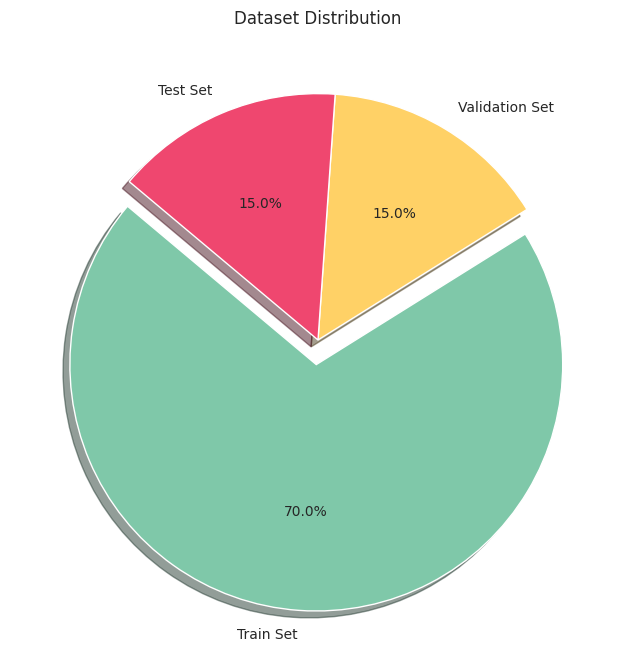

In [8]:
# Plot dataset distribution
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train Set', 'Validation Set', 'Test Set']
colors = ['#7FC8A9', '#FFD166', '#EF476F']
explode = (0.1, 0, 0)  # Explode the Train Set slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Dataset Distribution')
plt.show()

In [9]:
# Verify data information
print(f'Dataset Summary:')
print(f'TOTAL IMAGES: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')  # Total images from all sets
print(f'IMAGE SHAPE: {X_train.shape[1:]}')  # Image shape is the same for all datasets
print(f'CLASS LABELS: {CLASSES}')  # Ensure CLASSES is defined earlier
print(f'TRAIN SET: {X_train.shape[0]} images')
print(f'VALIDATION SET: {X_val.shape[0]} images')
print(f'TEST SET: {X_test.shape[0]} images')

Dataset Summary:
TOTAL IMAGES: 4000
IMAGE SHAPE: (224, 224, 3)
CLASS LABELS: ['Benign', 'Early', 'Pre', 'Pro']
TRAIN SET: 2800 images
VALIDATION SET: 600 images
TEST SET: 600 images


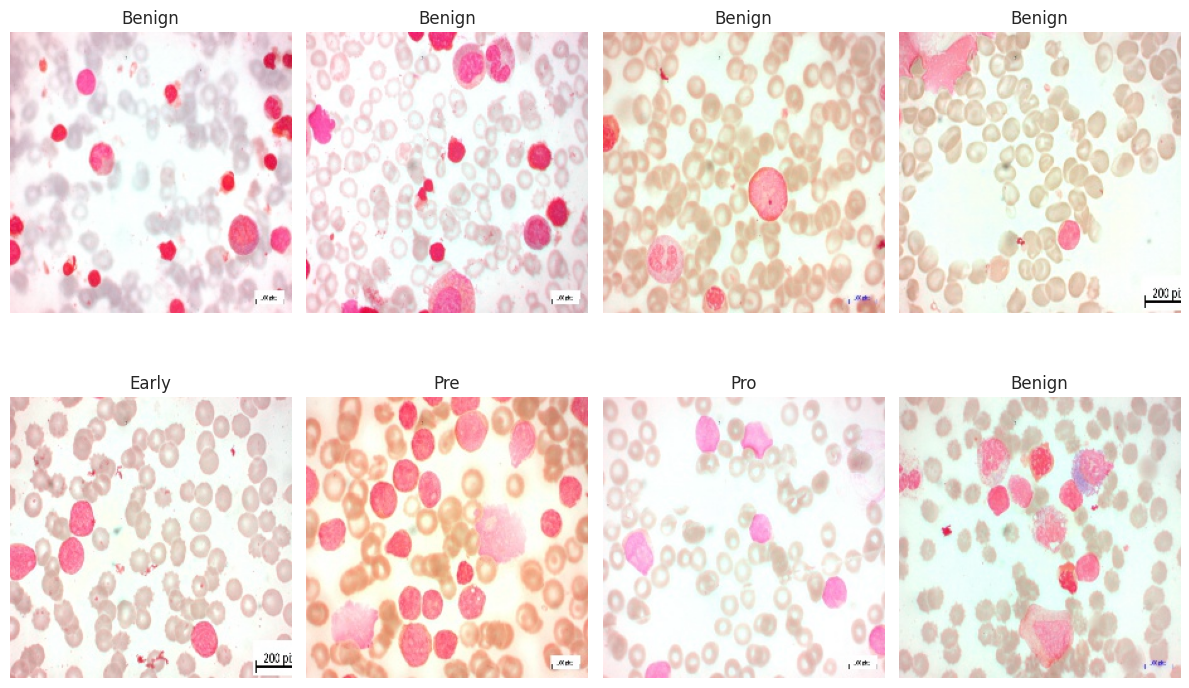

In [10]:
# Display sample images with their corresponding labels
plt.figure(figsize=(12, 8))
for i in range(8):  # Display 8 random samples
    idx = np.random.randint(len(X_train))
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[idx])
    label_idx = np.argmax(y_train[idx])  # Get class index from one-hot encoding
    plt.title(CLASSES[label_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# InceptionResNetV2

In [11]:
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "InceptionResNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,731,236 (208.78 MB)

 Trainable params: 394,500 (1.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

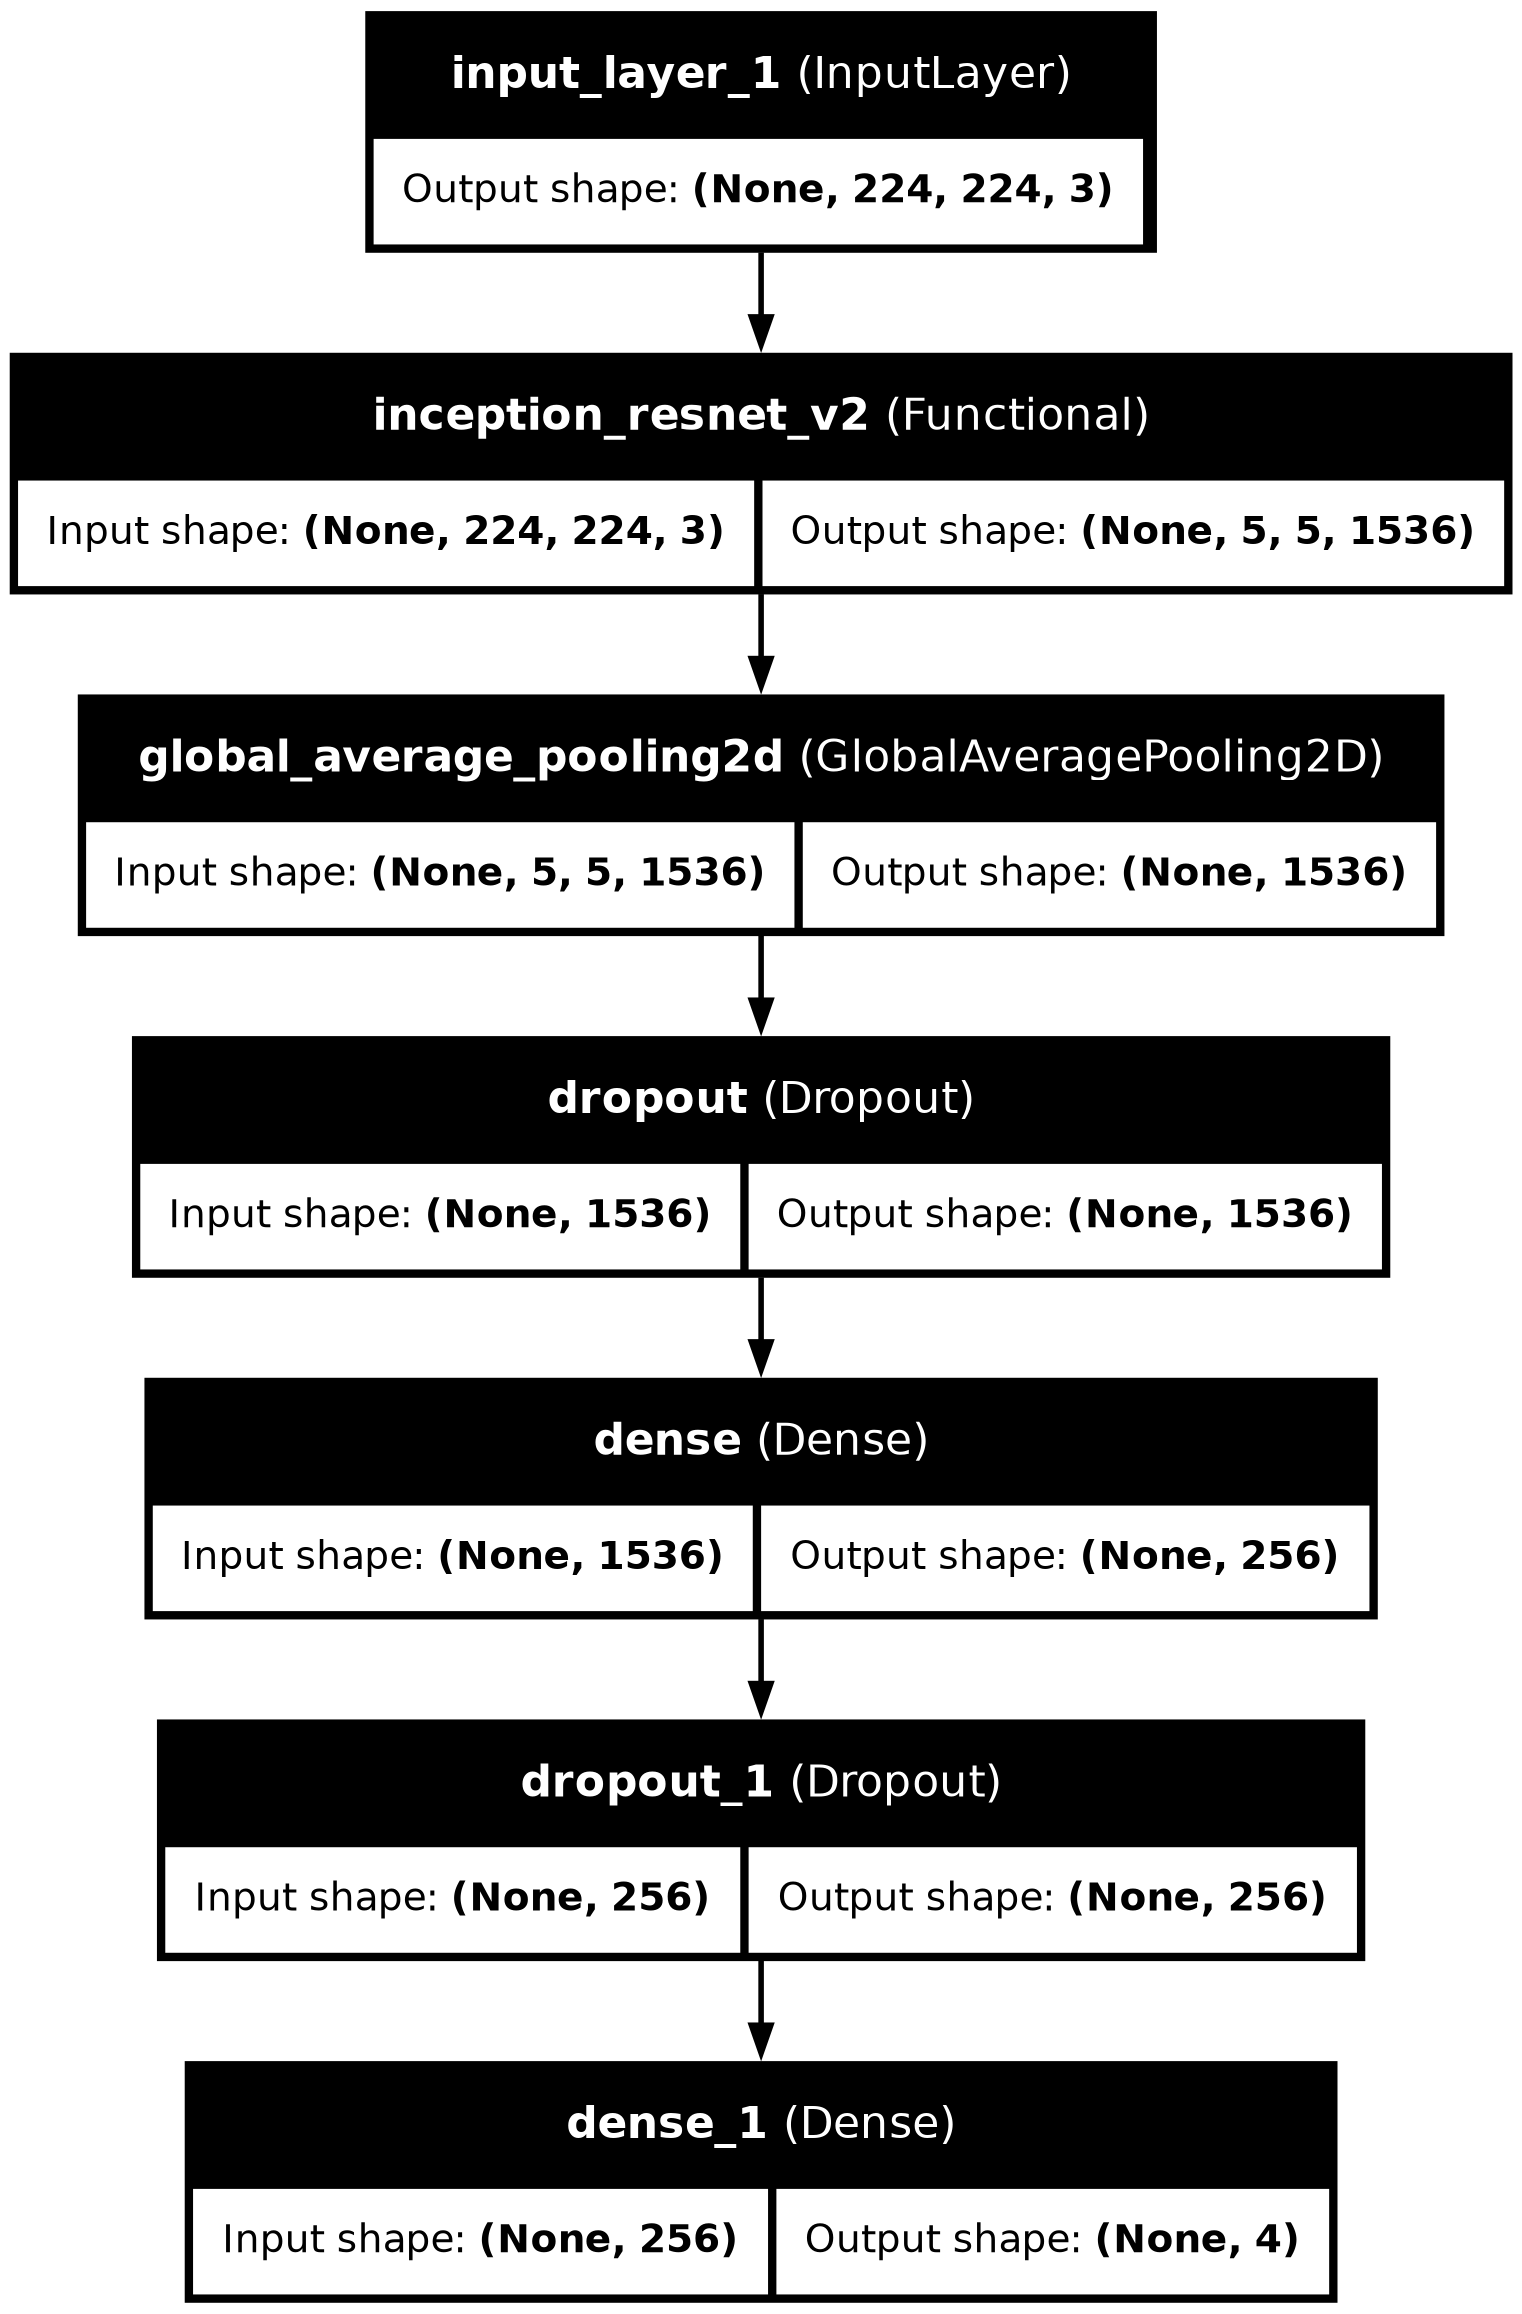

In [12]:
# Model architecture
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)

# Additional dense layer
x = Dense(256, activation='relu')(x) 
x = Dropout(DROPOUT_RATE)(x)

# Output layer
outputs = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs, outputs, name="InceptionResNetV2")
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# Compile the model with both loss and accuracy metrics
optimizer = Adam(learning_rate=LEARNING_RATE)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy']  # Add accuracy as a metric
)

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(f'{EXPERIMENT_NAME}_best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


I0000 00:00:1745647883.444130      90 service.cc:145] XLA service 0x7e7968004460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745647883.444180      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/88 ━━━━━━━━━━━━━━━━━━━━ 46:30 32s/step - accuracy: 0.2500 - loss: 1.6195

I0000 00:00:1745647896.763131      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 484ms/step - accuracy: 0.5637 - loss: 1.0633 - val_accuracy: 0.8750 - val_loss: 0.4661 - learning_rate: 1.0000e-04
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.8889 - loss: 0.4209 - val_accuracy: 0.9317 - val_loss: 0.2917 - learning_rate: 1.0000e-04
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9271 - loss: 0.2737 - val_accuracy: 0.9350 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9340 - loss: 0.2258 - val_accuracy: 0.9500 - val_loss: 0.1788 - learning_rate: 1.0000e-04
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9557 - loss: 0.1739 - val_accuracy: 0.9617 - val_loss: 0.1506 - learning_rate: 1.0000e-04
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9621 - loss: 0.1477 - val_accuracy: 0.9617 - val_loss: 0.1418 - learning_rate: 1.0000e-04
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.96

# Results

In [14]:
# Make predictions on the validation dataset
predictions = model.predict(val_ds)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Convert true labels from one-hot encoding to class labels if necessary
if true_labels.ndim > 1 and true_labels.shape[1] > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=CLASSES)
print(report)


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 642ms/step
              precision    recall  f1-score   support

      Benign       0.97      0.95      0.96       149
       Early       0.96      0.96      0.96       142
         Pre       0.99      0.99      0.99       149
         Pro       0.98      1.00      0.99       160

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [15]:
# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(train_ds)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_acc}")

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.9976 - loss: 0.0280
Training Loss: 0.029134908691048622
Training Accuracy: 0.9964285492897034
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9783 - loss: 0.0551
Validation Loss: 0.06499289721250534
Validation Accuracy: 0.9750000238418579
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9831 - loss: 0.0580
Test Loss: 0.05482904985547066
Test Accuracy: 0.9833333492279053


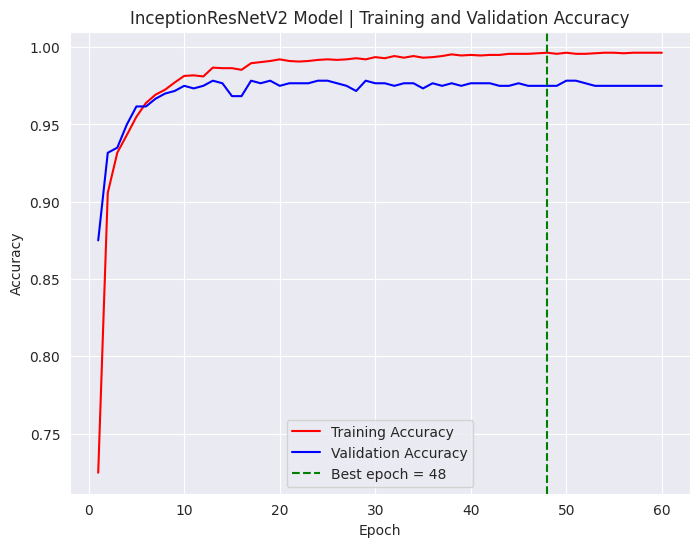

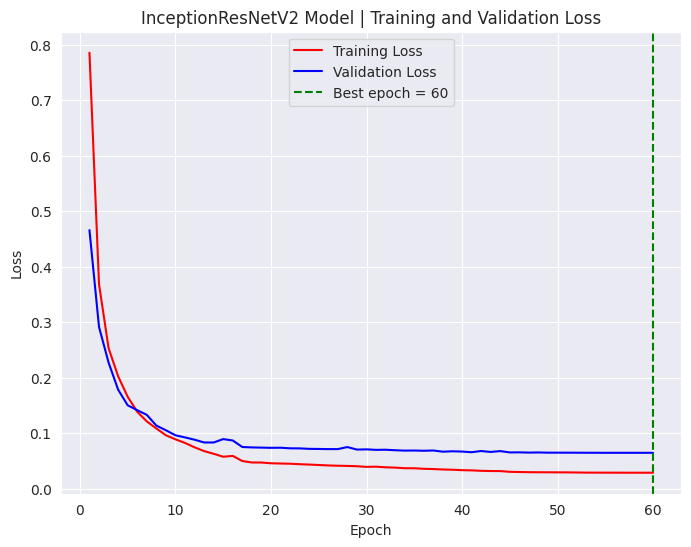

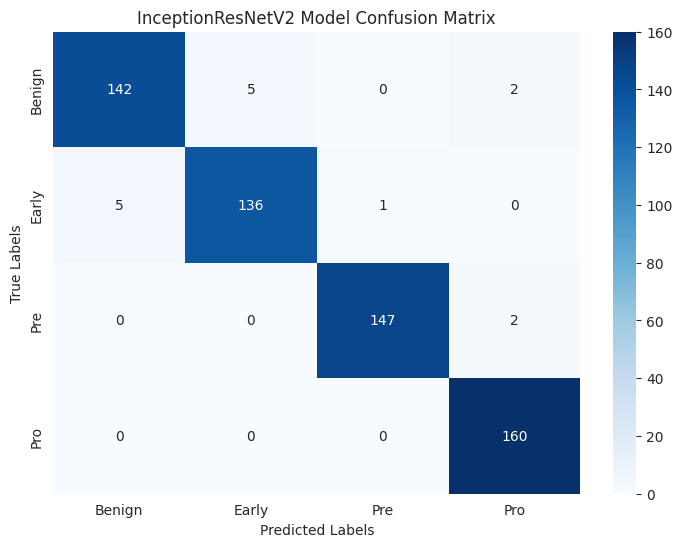

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 635ms/step


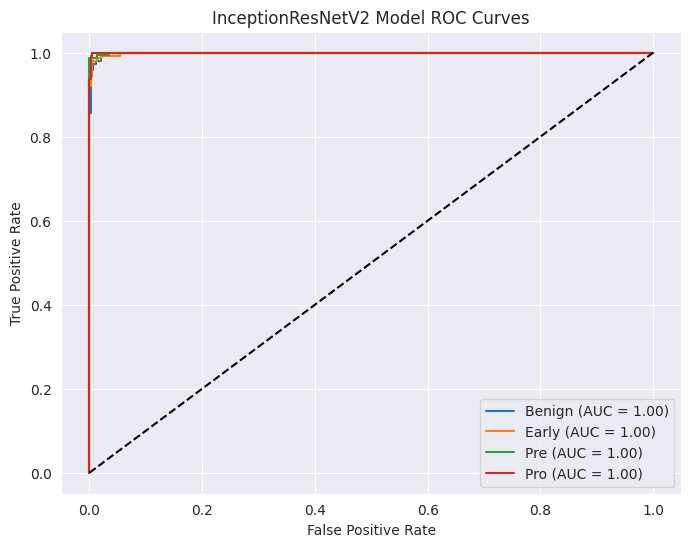

In [16]:
# Calculate best epochs
tr_acc = model_history.history['accuracy']
index_acc = np.argmax(tr_acc)  # Find epoch with highest training accuracy
index_loss = np.argmin(model_history.history['loss'])  # Find epoch with lowest training loss

# Plot accuracy and loss curves
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Accuracy plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b', label='Validation Accuracy')
plt.axvline(x=index_acc + 1, color='g', linestyle='--', label=f'Best epoch = {index_acc + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'b', label='Validation Loss')
plt.axvline(x=index_loss + 1, color='g', linestyle='--', label=f'Best epoch = {index_loss + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8.5, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('InceptionResNetV2 Model Confusion Matrix')
plt.show()

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=range(len(CLASSES)))

# Plot ROC Curves
plt.figure(figsize=(8, 6))
y_pred_proba = model.predict(X_test)
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionResNetV2 Model ROC Curves')
plt.legend()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Metrics Comparison Across Datasets:
-----------------------------------------------------------------
Metric          Training        Validation      Test           
-----------------------------------------------------------------
Loss                     0.0291          0.0650          0.0548
Accuracy                 0.9964          0.9750          0.9833
Precision                0.2410          0.9748          0.9832
Recall                   0.2410          0.9743          0.9837
F1-Score                 0.2410          0.9745          0.9833
-----------------------------------------------------------------


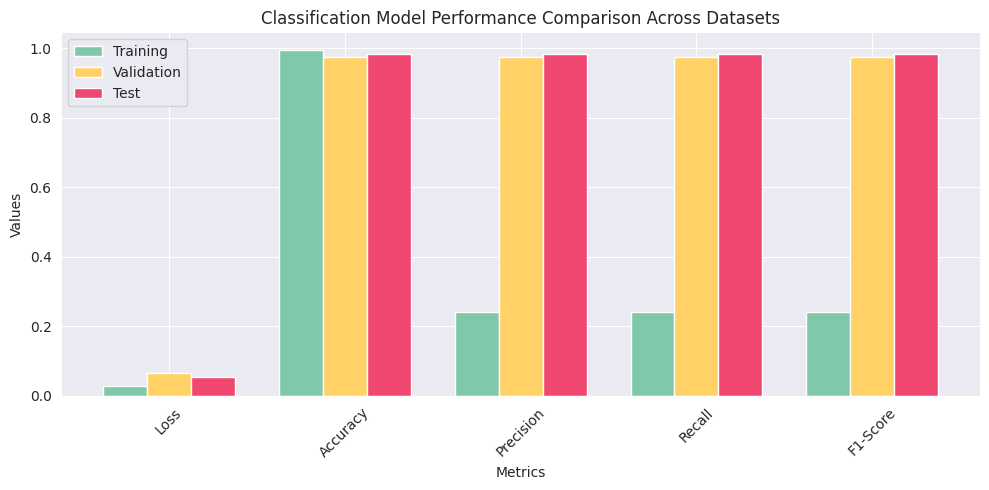

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
def evaluate_classification_model(model, dataset):
    return model.evaluate(dataset, verbose=0)

# Store results for comparison
results_dict = {}
# Get evaluation results without printing
results_dict['train'] = evaluate_classification_model(model, train_ds)
results_dict['val'] = evaluate_classification_model(model, val_ds)
results_dict['test'] = evaluate_classification_model(model, test_ds)

# Define the metrics names
metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Updated calculate_metrics function
def calculate_metrics(model, dataset):
    predictions = model.predict(dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.concatenate([y for x, y in dataset], axis=0)
    if true_labels.ndim > 1 and true_labels.shape[1] > 1:
        true_labels = np.argmax(true_labels, axis=1)
    
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    return [precision, recall, f1]

# Append additional metrics to results_dict
results_dict['train'] += calculate_metrics(model, train_ds)
results_dict['val'] += calculate_metrics(model, val_ds)
results_dict['test'] += calculate_metrics(model, test_ds)

# Create comparison table
print("\nMetrics Comparison Across Datasets:")
print("-" * 65)
print(f"{'Metric':15} {'Training':15} {'Validation':15} {'Test':15}")
print("-" * 65)
for i, metric in enumerate(metrics_names):
    train_val = results_dict['train'][i]
    val_val = results_dict['val'][i]
    test_val = results_dict['test'][i]
    print(f"{metric:15} {train_val:15.4f} {val_val:15.4f} {test_val:15.4f}")
print("-" * 65)

# Visualize metrics comparison
plt.figure(figsize=(10, 5))
x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, results_dict['train'], width, label='Training', color='#7FC8A9')
plt.bar(x, results_dict['val'], width, label='Validation', color='#FFD166')
plt.bar(x + width, results_dict['test'], width, label='Test', color='#EF476F')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classification Model Performance Comparison Across Datasets')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

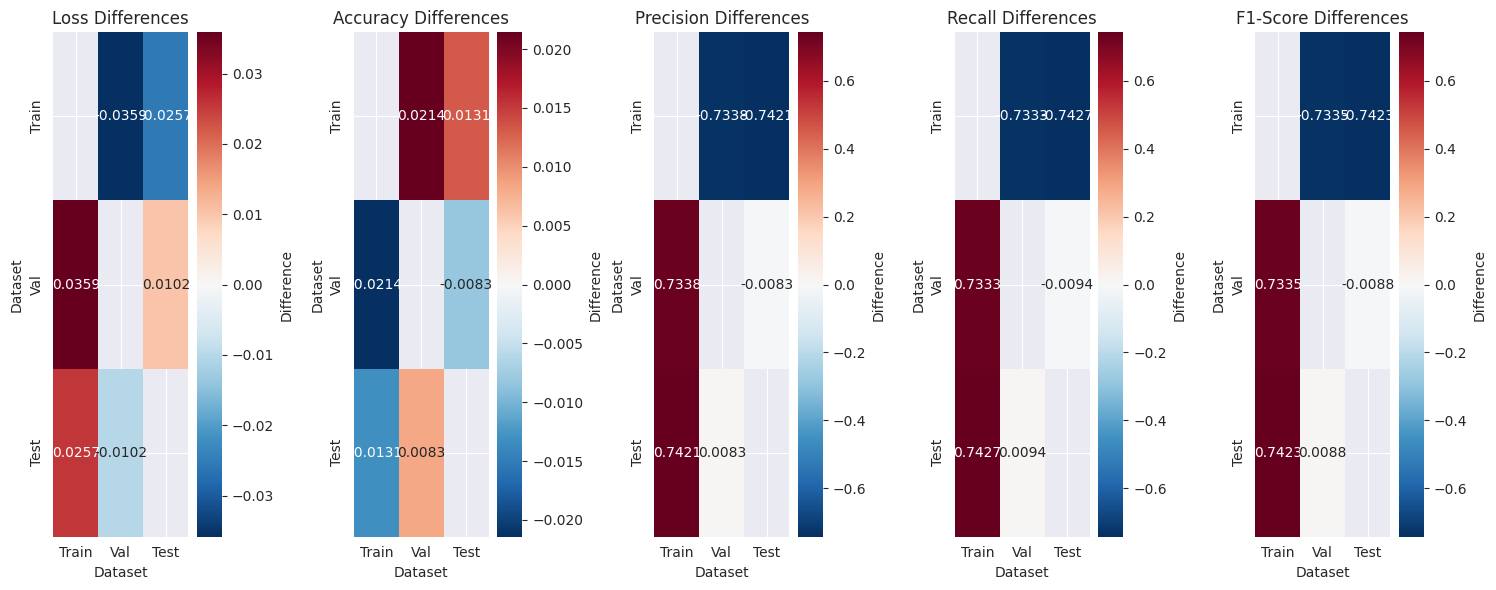


Detailed Metrics Differences Analysis:
----------------------------------------------------------------------

Loss Differences:
----------------------------------------
Train vs Val: -0.0359
Train vs Test: -0.0257
Val vs Test: +0.0102

Accuracy Differences:
----------------------------------------
Train vs Val: +0.0214
Train vs Test: +0.0131
Val vs Test: -0.0083

Precision Differences:
----------------------------------------
Train vs Val: -0.7338
   ⚠️ Large difference detected!
   • Val performs better than Train
Train vs Test: -0.7421
   ⚠️ Large difference detected!
   • Test performs better than Train
Val vs Test: -0.0083

Recall Differences:
----------------------------------------
Train vs Val: -0.7333
   ⚠️ Large difference detected!
   • Val performs better than Train
Train vs Test: -0.7427
   ⚠️ Large difference detected!
   • Test performs better than Train
Val vs Test: -0.0094

F1-Score Differences:
----------------------------------------
Train vs Val: -0.7335
   ⚠️ Larg

In [19]:
# Create heatmap for each metric
datasets = ['Train', 'Val', 'Test']
diff_matrix = np.zeros((len(metrics_names), len(datasets), len(datasets)))

# Calculate the differences
for i, metric in enumerate(metrics_names):
    for j, d1 in enumerate(datasets):
        for k, d2 in enumerate(datasets):
            if j != k:  # Skip comparing dataset with itself
                d1_lower = d1.lower()
                d2_lower = d2.lower()
                diff = results_dict[d1_lower][i] - results_dict[d2_lower][i]
                diff_matrix[i, j, k] = diff

# Create heatmaps for each metric
fig, axes = plt.subplots(1, len(metrics_names), figsize=(15, 6))
axes = axes.ravel()

for i, metric in enumerate(metrics_names):
    ax = axes[i]
    heatmap_data = diff_matrix[i]  # Extract data for the specific metric
    mask = np.eye(len(datasets), dtype=bool)  # Mask diagonal elements

    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.4f',
        cmap='RdBu_r',
        center=0,
        mask=mask,
        xticklabels=datasets,
        yticklabels=datasets,
        ax=ax,
        cbar_kws={'label': 'Difference'}
    )

    ax.set_title(f'{metric} Differences')
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Dataset')

plt.tight_layout()
plt.show()

# Print detailed differences
print("\nDetailed Metrics Differences Analysis:")
print("-" * 70)
for i, metric in enumerate(metrics_names):
    print(f"\n{metric} Differences:")
    print("-" * 40)
    for j, d1 in enumerate(datasets):
        for k, d2 in enumerate(datasets):
            if j < k:
                diff = diff_matrix[i, j, k]
                print(f"{d1} vs {d2}: {diff:+.4f}")
                if abs(diff) > 0.1:
                    print(f"   ⚠️ Large difference detected!")
                    if diff > 0:
                        print(f"   • {d1} performs better than {d2}")
                    else:
                        print(f"   • {d2} performs better than {d1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


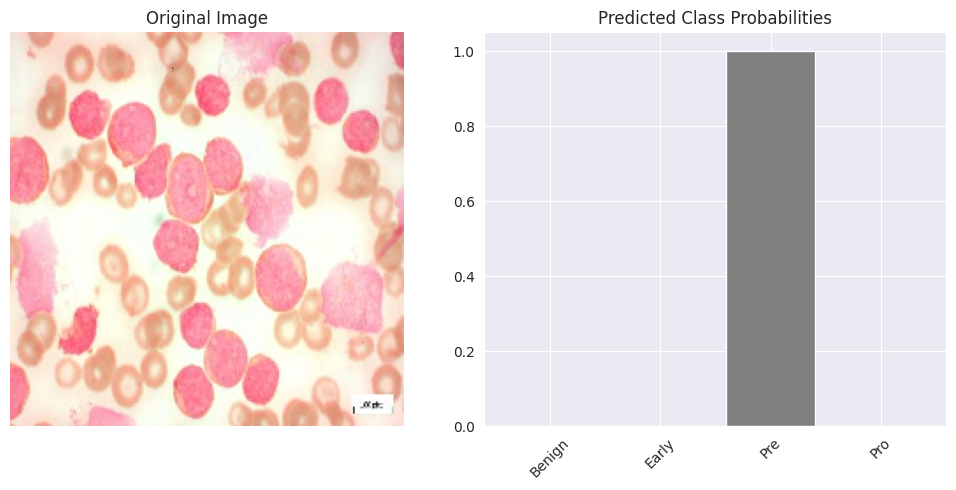

True Class: Pre
Predicted Class: Pre



In [20]:
# Visualization of individual predictions
def visualize_prediction(model, X_test, y_test, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X_test))

    test_img = X_test[idx]
    test_label = y_test[idx]

    # Make prediction
    test_pred = model.predict(test_img[np.newaxis, ...])
    predicted_class = np.argmax(test_pred)
    true_class = np.argmax(test_label) if test_label.ndim > 0 else test_label

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax1.imshow(test_img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Prediction result
    ax2.bar(range(len(CLASSES)), test_pred[0], color='gray')
    ax2.set_xticks(range(len(CLASSES)))
    ax2.set_xticklabels(CLASSES, rotation=45)
    ax2.set_title('Predicted Class Probabilities')

    plt.tight_layout()
    plt.show()

    print(f"True Class: {CLASSES[true_class]}\nPredicted Class: {CLASSES[predicted_class]}\n")

# Visualize a random prediction
visualize_prediction(model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


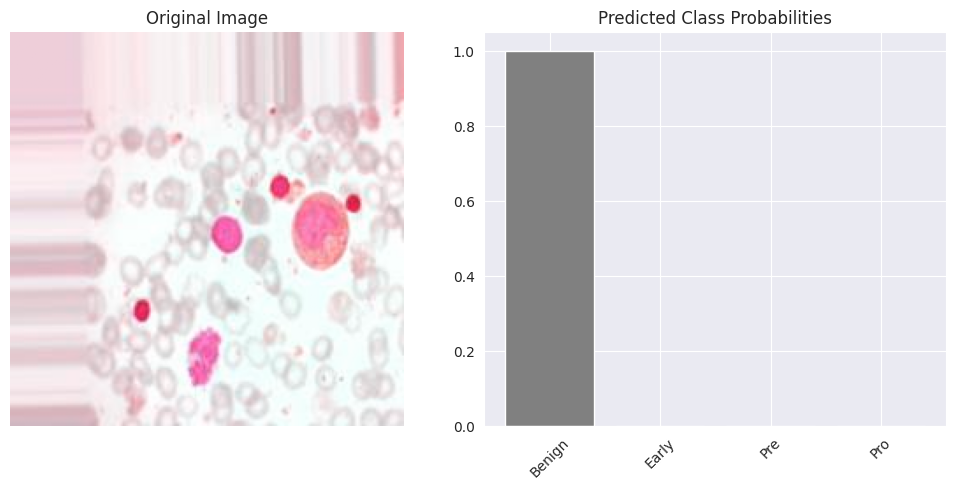

True Class: Benign
Predicted Class: Benign



In [21]:
# Visualization of individual predictions
def visualize_prediction(model, X_test, y_test, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X_test))

    test_img = X_test[idx]
    test_label = y_test[idx]

    # Make prediction
    test_pred = model.predict(test_img[np.newaxis, ...])
    predicted_class = np.argmax(test_pred)
    true_class = np.argmax(test_label) if test_label.ndim > 0 else test_label

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax1.imshow(test_img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Prediction result
    ax2.bar(range(len(CLASSES)), test_pred[0], color='gray')
    ax2.set_xticks(range(len(CLASSES)))
    ax2.set_xticklabels(CLASSES, rotation=45)
    ax2.set_title('Predicted Class Probabilities')

    plt.tight_layout()
    plt.show()

    print(f"True Class: {CLASSES[true_class]}\nPredicted Class: {CLASSES[predicted_class]}\n")

# Visualize a random prediction
visualize_prediction(model, X_test, y_test)

# Save Model

In [ ]:
model.save('InceptionResNetV2_model.h5')

# model.save('InceptionResNetV2_model.keras')